In [17]:
import torch
import numpy as np

torch.__version__

'1.0.1.post2'

In [64]:
# Load data to dataloader

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch = 16
new_train_size=10000
shuffle_dataset=True
random_seed=42

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)

train_size=len(train_data)
indices=list(range(train_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices=indices[:new_train_size]
train_sampler=SubsetRandomSampler(train_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,sampler=train_sampler)

test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch)

len(train_data)
len(train_loader)

625

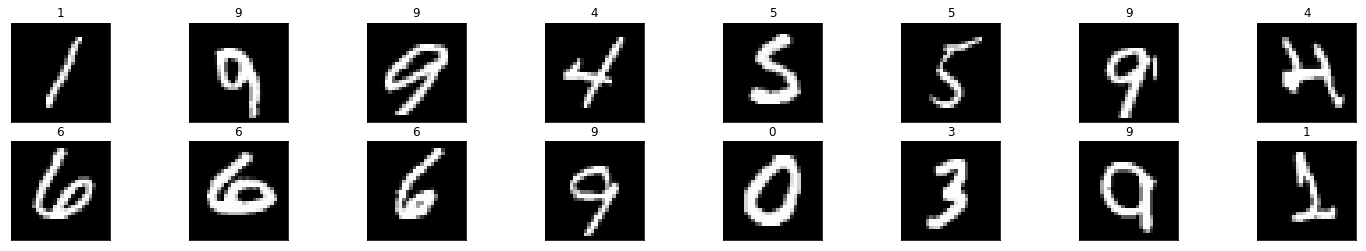

In [65]:
# Input visualization

import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))


In [31]:
len(train_loader)

2625

In [86]:
# Define the network architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super (Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,              
                stride=1, padding=2,                 
            ),
            nn.ReLU(),                     
            nn.MaxPool2d(kernel_size=2),   
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),    
            nn.ReLU(),                     
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

model = Net()
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [87]:
# Define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [88]:
# Training for 30 epochs

n_epochs = 20
model.train()

for epoch in range(n_epochs):
    train_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    print('Epoch is:', epoch)
    print('Training loss is:', train_loss/len(train_loader.dataset))

Epoch is: 0
Training loss is: 0.37638660666147866
Epoch is: 1
Training loss is: 0.34635556440353393
Epoch is: 2
Training loss is: 0.23901162169774373
Epoch is: 3
Training loss is: 0.1261476873954137
Epoch is: 4
Training loss is: 0.08781861596902212
Epoch is: 5
Training loss is: 0.07272085480292638
Epoch is: 6
Training loss is: 0.06445222396453222


KeyboardInterrupt: 

In [89]:
# Testing

test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))


model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)

print('Test loss:', test_loss)

print('Overall Test Accuracy:', (np.sum(class_correct)) / np.sum(class_total))

Test loss: 0.33145834159851073
Overall Test Accuracy: 0.9046


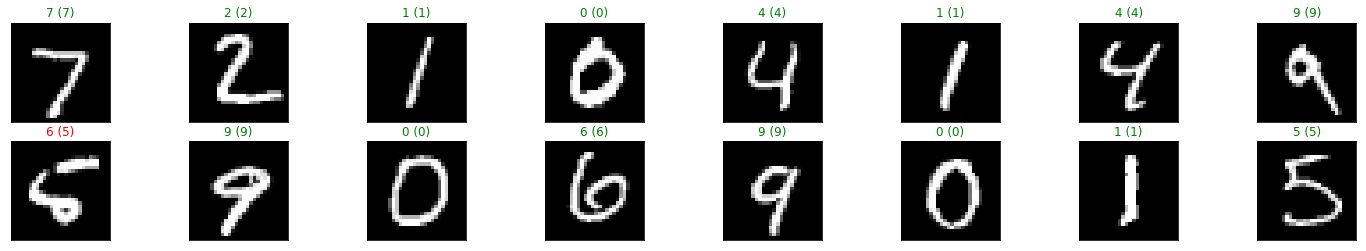

In [8]:
# Result visualization

dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))